## Train Utils

In [2]:
"""Classify a Gaussian mixture model and calibrated different GGNs."""


import argparse
import os
import pickle



import jax
import jax.numpy as jnp
from flax import linen as nn
from jax import nn as jnn
from jax.numpy.linalg import matrix_rank
from jax.experimental.ode import odeint

import matplotlib.pyplot as plt
import optax
from tueplots import bundles
config_plt = bundles.neurips2023()
config_plt['text.usetex'] = False
plt.rcParams.update(config_plt)


In [26]:
print(matrix_rank(jax.random.normal(jax.random.PRNGKey(0), (400, 5442))))

400


In [3]:
class MLP(nn.Module):
    output_dim: 1
    hidden_dim: 64
    num_layers: 3
    activation: "tanh"

    def act_fun(self, x):
        if self.activation == "tanh":
            return jnn.tanh(x)
        if self.activation == "relu":
            return jnn.relu(x)
    @nn.compact
    def __call__(self, x):
        x = x.reshape((x.shape[0], -1))
        for _ in range(self.num_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = self.act_fun(x)
        x = nn.Dense(self.output_dim)(x)
        return x

def cross_entropy_loss(preds, y, rho=1.0):
    """
    preds: (n_samples, n_classes) (logits)
    y: (n_samples, n_classes) (one-hot labels)
    """
    preds = preds * rho
    preds = jax.nn.log_softmax(preds, axis=-1)
    return -jnp.sum(jnp.sum(preds * y, axis=-1))

def accuracy(params, model, batch_x, batch_y):
    preds = model.apply(params, batch_x)
    return jnp.sum(preds.argmax(axis=-1) == batch_y.argmax(axis=-1))

def accuracy_preds(preds, batch_y):
    return jnp.sum(preds.argmax(axis=-1) == batch_y.argmax(axis=-1))


In [4]:
seed = 1
num_data_in = 100
train_num_epochs = 100
train_batch_size = num_data_in * 2
train_lrate = 1e-2
train_print_frequency = 10

# Create data
key = jax.random.PRNGKey(seed)
key, key_1, key_2 = jax.random.split(key, num=3)
m = 1.0
mu_1, mu_2 = jnp.array((-m, m)), jnp.array((m, -m))
# x_1 = 0.7 * jax.random.normal(key_1, (num_data_in, 2)) + mu_1[None, :]
x_1 = 0.5 * jax.random.normal(key_1, (num_data_in, 2))
y_1 = jnp.asarray(num_data_in * [[1, 0]])

# x_2 = 0.7 * jax.random.normal(key_2, (num_data_in, 2)) + mu_2[None, :]
theta = jax.random.uniform(key_2, minval=0, maxval=2 * jnp.pi, shape=(num_data_in,))
r = jax.random.uniform(key_2, minval=0.6, maxval=1.5, shape=(num_data_in,))
x_2 = r.reshape(-1,1) * jnp.stack((jnp.cos(theta), jnp.sin(theta)), axis=-1)
# x_2 = 2.5 * jax.random.normal(key_1, (num_data_in, 2)) - 0.5 * jax.random.normal(key_1, (num_data_in, 2))
y_2 = jnp.asarray(num_data_in * [[0, 1]])
x_train = jnp.concatenate([x_1, x_2], axis=0)
y_train = jnp.concatenate([y_1, y_2], axis=0)



In [5]:
plot_num_linspace = 250
plot_xmin, plot_xmax = -7, 7
plot_figsize = (8, 3)

x_1d = jnp.linspace(plot_xmin, plot_xmax, num=plot_num_linspace)
x_plot_x, x_plot_y = jnp.meshgrid(x_1d, x_1d)
x_plot = jnp.stack((x_plot_x, x_plot_y)).reshape((2, -1)).T

bdry = {"vmin": 0, "vmax": 1, "cmap": "seismic", "zorder": 0, "alpha": 0.5}
in_data_1 = {  "color": "black",
        "zorder": 1,
        "linestyle": "None",
        "marker": "o",
        "markeredgecolor": "grey",
        "alpha": 0.75,
    }

in_data_2 = {  "color": "white",
        "zorder": 1,
        "linestyle": "None",
        "marker": "o",
        "markeredgecolor": "grey",
        "alpha": 0.75,
    }

In [15]:
import numpy as np

def matrix_rank(A, hermitian=False, rtol=None):
    A = np.asarray(A)
    S = np.linalg.svd(A, compute_uv=False, hermitian=hermitian)
    if rtol is None:
        rtol = np.finfo(S.dtype).eps#max(A.shape[-2:]) * np.finfo(S.dtype).eps
        tol = S.max(axis=-1, keepdims=True) * rtol
    return np.count_nonzero(S > tol, axis=-1)


In [16]:
#Functions
import numpy as np
threshold = None

def init(model, key):
  variables_dict = model.init(key, x_train)
  model_apply = model.apply
  variables, unflatten = jax.flatten_util.ravel_pytree(variables_dict)
  model_apply_vectorised = lambda v, x: model_apply(unflatten(v), x)
  return variables, model_apply_vectorised




def train(model, key):
  stop_after = 1000
  variables_dict = model.init(key, x_train)
  model_apply = model.apply
  variables, unflatten = jax.flatten_util.ravel_pytree(variables_dict)
  model_apply_vectorised = lambda v, x: model_apply(unflatten(v), x)
  # Train the model

  optimizer = optax.adam(train_lrate)
  optimizer_state = optimizer.init(variables)


  def loss_p(v, x, y):
      logits = model_apply(unflatten(v), x)
      return cross_entropy_loss(preds=logits, y=y)


  loss_value_and_grad = jax.jit(jax.value_and_grad(loss_p, argnums=0))
  epoch = 0
  acc = 0
  best_acc, idx_best = 0, 0
  # for epoch in range(train_num_epochs):
  while acc < 0.9999 and (epoch - idx_best) < stop_after:
      epoch += 1
      # Subsample data
      key, subkey = jax.random.split(key)
      idx = jax.random.choice(
          subkey, x_train.shape[0], (train_batch_size,), replace=False
      )

      # Apply an optimizer-step
      loss, grad = loss_value_and_grad(variables, x_train[idx], y_train[idx])
      updates, optimizer_state = optimizer.update(grad, optimizer_state)
      variables = optax.apply_updates(variables, updates)

      # Look at intermediate results
      if epoch % train_print_frequency == 0:
          y_pred = model_apply(unflatten(variables), x_train[idx])
          y_probs = jax.nn.softmax(y_pred, axis=-1)
          acc = accuracy_preds(preds=y_probs, batch_y=y_train[idx])/train_batch_size
          print(f"Epoch {epoch}, loss {loss:.3f}, accuracy {acc:.3f}")
          if acc > best_acc:
            best_acc = acc
            idx_best = epoch
            best_variables = variables
  logits_plot = model_apply(unflatten(variables), x_plot)
  labels_plot = jax.nn.log_softmax(logits_plot).argmax(axis=-1)
  labels_plot = labels_plot.T.reshape((plot_num_linspace, plot_num_linspace))
  plt.figure()
  plt.title("Decision boundary")
  plt.contourf(x_plot_x, x_plot_y, labels_plot, 3, **bdry)
  plt.plot(x_train[:num_data_in, 0], x_train[:num_data_in, 1], **in_data_1)
  plt.plot(x_train[num_data_in:, 0], x_train[num_data_in:, 1], **in_data_2)
  plt.colorbar()
  plt.show()

  return best_variables, model_apply_vectorised

def rank(width, depth, key):
  model = MLP(2, width, depth, "tanh")
  variables, model_apply_vectorised = init(model, key)
  model_p = lambda v: model_apply_vectorised(v, x_train)
  J = jax.jacobian(model_p, argnums=0)(variables)
  J = J.reshape(-1,variables.shape[0])
  # rank_init = np.linalg.matrix_rank(J, tol=threshold)
  rank_init = matrix_rank(J, rtol=threshold)

  variables, model_apply_vectorised = train(model, key)
  model_p = lambda v: model_apply_vectorised(v, x_train)
  J = jax.jacobian(model_p, argnums=0)(variables)
  J = J.reshape(-1,variables.shape[0])
  # rank_train = np.linalg.matrix_rank(J, tol=threshold)
  rank_train = matrix_rank(J, rtol=threshold)

  return rank_init, rank_train, len(variables)


Epoch 10, loss 131.902, accuracy 0.625
Epoch 20, loss 111.583, accuracy 0.725
Epoch 30, loss 82.671, accuracy 0.820
Epoch 40, loss 67.586, accuracy 0.880
Epoch 50, loss 58.792, accuracy 0.885
Epoch 60, loss 52.818, accuracy 0.915
Epoch 70, loss 50.335, accuracy 0.915
Epoch 80, loss 47.958, accuracy 0.915
Epoch 90, loss 46.269, accuracy 0.935
Epoch 100, loss 43.108, accuracy 0.930
Epoch 110, loss 44.486, accuracy 0.950
Epoch 120, loss 41.585, accuracy 0.950
Epoch 130, loss 38.373, accuracy 0.945
Epoch 140, loss 37.252, accuracy 0.935
Epoch 150, loss 35.853, accuracy 0.950
Epoch 160, loss 34.863, accuracy 0.945
Epoch 170, loss 34.052, accuracy 0.945
Epoch 180, loss 33.495, accuracy 0.945
Epoch 190, loss 33.280, accuracy 0.945
Epoch 200, loss 34.076, accuracy 0.945
Epoch 210, loss 31.937, accuracy 0.945
Epoch 220, loss 30.348, accuracy 0.945
Epoch 230, loss 144.281, accuracy 0.845
Epoch 240, loss 83.695, accuracy 0.780
Epoch 250, loss 64.753, accuracy 0.870
Epoch 260, loss 47.853, accurac

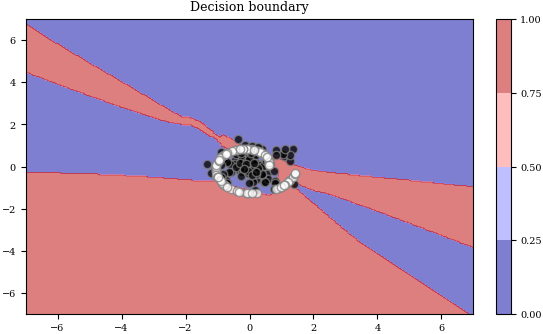

(186, 281, 898)

In [17]:
rank(16, 4, key)


### Plots

Epoch 10, loss 128.252, accuracy 0.680
Epoch 20, loss 112.750, accuracy 0.680
Epoch 30, loss 94.465, accuracy 0.800
Epoch 40, loss 78.078, accuracy 0.865
Epoch 50, loss 68.533, accuracy 0.880
Epoch 60, loss 62.255, accuracy 0.890
Epoch 70, loss 57.103, accuracy 0.895
Epoch 80, loss 53.796, accuracy 0.915
Epoch 90, loss 51.348, accuracy 0.920
Epoch 100, loss 49.546, accuracy 0.920
Epoch 110, loss 47.867, accuracy 0.925
Epoch 120, loss 46.466, accuracy 0.930
Epoch 130, loss 45.268, accuracy 0.935
Epoch 140, loss 44.623, accuracy 0.925
Epoch 150, loss 43.286, accuracy 0.935
Epoch 160, loss 42.350, accuracy 0.925
Epoch 170, loss 41.366, accuracy 0.940
Epoch 180, loss 40.361, accuracy 0.945
Epoch 190, loss 39.384, accuracy 0.950
Epoch 200, loss 38.345, accuracy 0.945


Epoch 210, loss 37.486, accuracy 0.950
Epoch 220, loss 36.577, accuracy 0.945
Epoch 230, loss 35.684, accuracy 0.950
Epoch 240, loss 34.983, accuracy 0.950
Epoch 250, loss 34.243, accuracy 0.950
Epoch 260, loss 33.609, accuracy 0.945
Epoch 270, loss 32.909, accuracy 0.945
Epoch 280, loss 32.504, accuracy 0.940
Epoch 290, loss 31.716, accuracy 0.945
Epoch 300, loss 31.157, accuracy 0.945
Epoch 310, loss 30.600, accuracy 0.950
Epoch 320, loss 30.045, accuracy 0.950
Epoch 330, loss 29.668, accuracy 0.945
Epoch 340, loss 29.174, accuracy 0.955
Epoch 350, loss 28.622, accuracy 0.960
Epoch 360, loss 28.142, accuracy 0.960
Epoch 370, loss 27.732, accuracy 0.960
Epoch 380, loss 27.368, accuracy 0.960
Epoch 390, loss 27.024, accuracy 0.960
Epoch 400, loss 26.703, accuracy 0.960
Epoch 410, loss 26.400, accuracy 0.960
Epoch 420, loss 26.114, accuracy 0.960
Epoch 430, loss 25.842, accuracy 0.960
Epoch 440, loss 25.582, accuracy 0.960
Epoch 450, loss 25.333, accuracy 0.960
Epoch 460, loss 25.092, a

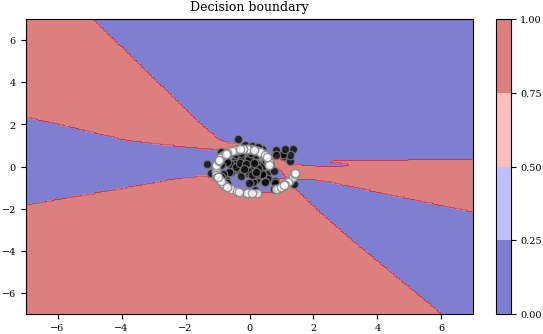

Width: 16, Rank Init: 143, Rank Train: 278
Epoch 10, loss 131.108, accuracy 0.650
Epoch 20, loss 118.112, accuracy 0.715
Epoch 30, loss 98.607, accuracy 0.790
Epoch 40, loss 80.964, accuracy 0.880
Epoch 50, loss 70.622, accuracy 0.885
Epoch 60, loss 64.139, accuracy 0.885
Epoch 70, loss 59.800, accuracy 0.895
Epoch 80, loss 55.804, accuracy 0.905
Epoch 90, loss 52.789, accuracy 0.915
Epoch 100, loss 50.164, accuracy 0.915
Epoch 110, loss 47.810, accuracy 0.925
Epoch 120, loss 45.582, accuracy 0.930
Epoch 130, loss 43.506, accuracy 0.940
Epoch 140, loss 41.559, accuracy 0.940
Epoch 150, loss 39.841, accuracy 0.940
Epoch 160, loss 38.341, accuracy 0.945
Epoch 170, loss 37.025, accuracy 0.950
Epoch 180, loss 35.848, accuracy 0.955
Epoch 190, loss 34.783, accuracy 0.955
Epoch 200, loss 33.805, accuracy 0.955
Epoch 210, loss 32.885, accuracy 0.955
Epoch 220, loss 32.114, accuracy 0.955
Epoch 230, loss 31.141, accuracy 0.955
Epoch 240, loss 30.325, accuracy 0.955
Epoch 250, loss 29.470, accu

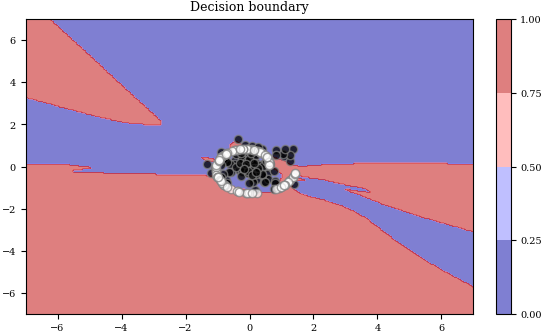

Width: 32, Rank Init: 186, Rank Train: 346
Epoch 10, loss 130.379, accuracy 0.605
Epoch 20, loss 114.012, accuracy 0.695
Epoch 30, loss 95.180, accuracy 0.820
Epoch 40, loss 77.485, accuracy 0.870
Epoch 50, loss 65.302, accuracy 0.890
Epoch 60, loss 57.829, accuracy 0.905
Epoch 70, loss 53.710, accuracy 0.925
Epoch 80, loss 49.855, accuracy 0.925
Epoch 90, loss 46.864, accuracy 0.930
Epoch 100, loss 44.387, accuracy 0.935
Epoch 110, loss 42.133, accuracy 0.940
Epoch 120, loss 40.031, accuracy 0.940
Epoch 130, loss 38.001, accuracy 0.945
Epoch 140, loss 36.131, accuracy 0.950
Epoch 150, loss 34.493, accuracy 0.950
Epoch 160, loss 32.999, accuracy 0.955
Epoch 170, loss 31.601, accuracy 0.955
Epoch 180, loss 30.284, accuracy 0.950
Epoch 190, loss 28.976, accuracy 0.950
Epoch 200, loss 27.625, accuracy 0.955
Epoch 210, loss 26.133, accuracy 0.955
Epoch 220, loss 24.484, accuracy 0.960
Epoch 230, loss 22.843, accuracy 0.960
Epoch 240, loss 21.263, accuracy 0.955
Epoch 250, loss 20.257, accu

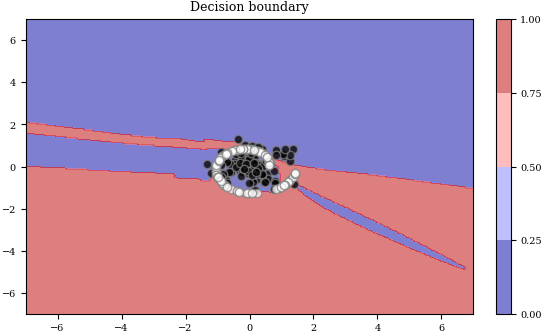

Width: 64, Rank Init: 206, Rank Train: 384
Epoch 10, loss 145.540, accuracy 0.605
Epoch 20, loss 117.937, accuracy 0.690
Epoch 30, loss 98.104, accuracy 0.845
Epoch 40, loss 78.321, accuracy 0.865
Epoch 50, loss 65.728, accuracy 0.885
Epoch 60, loss 57.501, accuracy 0.890
Epoch 70, loss 52.353, accuracy 0.900
Epoch 80, loss 48.848, accuracy 0.920
Epoch 90, loss 46.093, accuracy 0.930
Epoch 100, loss 43.438, accuracy 0.935
Epoch 110, loss 41.051, accuracy 0.935
Epoch 120, loss 38.803, accuracy 0.945
Epoch 130, loss 36.700, accuracy 0.950
Epoch 140, loss 34.708, accuracy 0.950
Epoch 150, loss 32.931, accuracy 0.950
Epoch 160, loss 31.326, accuracy 0.955
Epoch 170, loss 29.837, accuracy 0.955
Epoch 180, loss 28.338, accuracy 0.955
Epoch 190, loss 26.792, accuracy 0.955
Epoch 200, loss 25.155, accuracy 0.960
Epoch 210, loss 23.389, accuracy 0.960
Epoch 220, loss 21.501, accuracy 0.960
Epoch 230, loss 19.666, accuracy 0.965
Epoch 240, loss 17.897, accuracy 0.975
Epoch 250, loss 16.531, accu

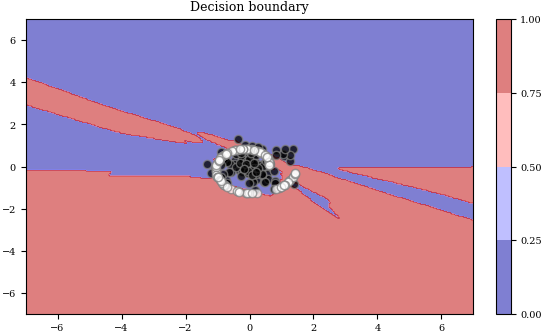

Width: 128, Rank Init: 215, Rank Train: 390
Epoch 10, loss 151.226, accuracy 0.630
Epoch 20, loss 123.577, accuracy 0.620
Epoch 30, loss 105.107, accuracy 0.760
Epoch 40, loss 95.766, accuracy 0.815
Epoch 50, loss 85.443, accuracy 0.855
Epoch 60, loss 76.390, accuracy 0.860
Epoch 70, loss 67.741, accuracy 0.870
Epoch 80, loss 59.987, accuracy 0.885
Epoch 90, loss 54.611, accuracy 0.905
Epoch 100, loss 47.989, accuracy 0.935
Epoch 110, loss 43.444, accuracy 0.940
Epoch 120, loss 39.664, accuracy 0.945
Epoch 130, loss 36.922, accuracy 0.945
Epoch 140, loss 34.770, accuracy 0.950
Epoch 150, loss 33.017, accuracy 0.950
Epoch 160, loss 31.533, accuracy 0.950
Epoch 170, loss 30.243, accuracy 0.955
Epoch 180, loss 29.080, accuracy 0.955
Epoch 190, loss 28.030, accuracy 0.955
Epoch 200, loss 27.062, accuracy 0.955
Epoch 210, loss 26.115, accuracy 0.955
Epoch 220, loss 25.206, accuracy 0.955
Epoch 230, loss 24.300, accuracy 0.955
Epoch 240, loss 23.384, accuracy 0.955
Epoch 250, loss 22.408, ac

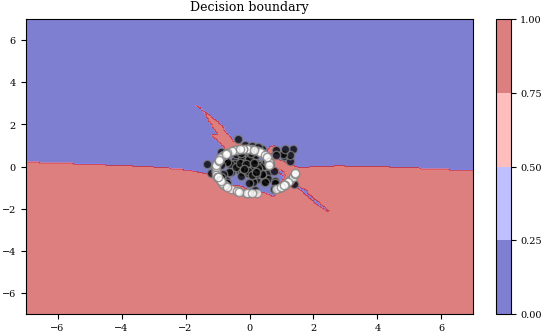

Width: 256, Rank Init: 229, Rank Train: 400


In [18]:
depth = 2
width_list = jnp.array([16, 32, 64, 128, 256])
rank_init_list, rank_train_list, num_params_list = [], [], []
for width in width_list:
  rank_init, rank_train, num_params = rank(width, depth, key)
  rank_init_list.append(rank_init)
  rank_train_list.append(rank_train)
  num_params_list.append(num_params)
  print(f"Width: {width}, Rank Init: {rank_init}, Rank Train: {rank_train}")
ker_init_list, ker_train_list = [p - r for p,r in zip(num_params_list, rank_init_list)], [p - r for p,r in zip(num_params_list, rank_train_list)]

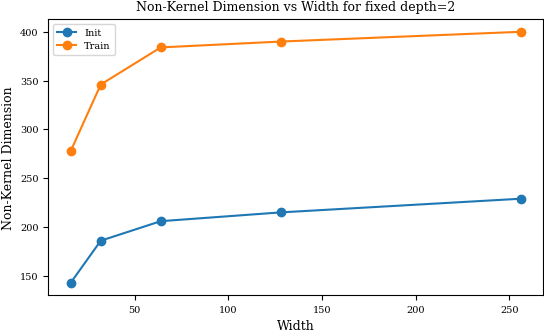

In [19]:
plt.plot(width_list, rank_init_list, marker='o', label="Init")
plt.plot(width_list, rank_train_list, marker='o', label="Train")
plt.legend()
plt.xlabel("Width")
plt.ylabel("Non-Kernel Dimension")
plt.title("Non-Kernel Dimension vs Width for fixed depth=2")
plt.savefig("Fixed_depth_2.pdf")

In [24]:
num_params_list

[1218, 3330, 5442, 7554, 9666]

Text(0.5, 1.0, 'Non-Kernel Dimension vs Num Params for fixed depth=2')

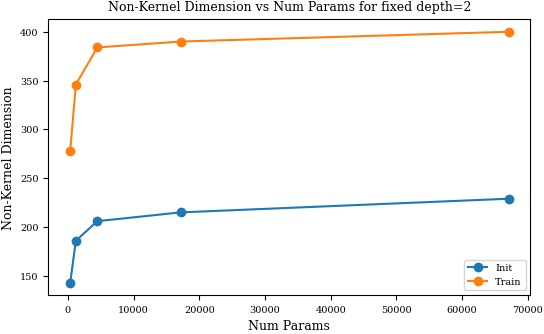

In [20]:
plt.plot(num_params_list, rank_init_list, marker='o', label="Init")
plt.plot(num_params_list, rank_train_list, marker='o', label="Train")
plt.legend()
plt.xlabel("Num Params")
plt.ylabel("Non-Kernel Dimension")
plt.title("Non-Kernel Dimension vs Num Params for fixed depth=2")

Epoch 10, loss 131.108, accuracy 0.650
Epoch 20, loss 118.112, accuracy 0.715
Epoch 30, loss 98.607, accuracy 0.790
Epoch 40, loss 80.964, accuracy 0.880
Epoch 50, loss 70.622, accuracy 0.885
Epoch 60, loss 64.139, accuracy 0.885
Epoch 70, loss 59.800, accuracy 0.895
Epoch 80, loss 55.804, accuracy 0.905
Epoch 90, loss 52.789, accuracy 0.915
Epoch 100, loss 50.164, accuracy 0.915
Epoch 110, loss 47.810, accuracy 0.925
Epoch 120, loss 45.582, accuracy 0.930
Epoch 130, loss 43.506, accuracy 0.940
Epoch 140, loss 41.559, accuracy 0.940
Epoch 150, loss 39.841, accuracy 0.940
Epoch 160, loss 38.341, accuracy 0.945


Epoch 170, loss 37.025, accuracy 0.950
Epoch 180, loss 35.848, accuracy 0.955
Epoch 190, loss 34.783, accuracy 0.955
Epoch 200, loss 33.805, accuracy 0.955
Epoch 210, loss 32.885, accuracy 0.955
Epoch 220, loss 32.114, accuracy 0.955
Epoch 230, loss 31.141, accuracy 0.955
Epoch 240, loss 30.325, accuracy 0.955
Epoch 250, loss 29.470, accuracy 0.955
Epoch 260, loss 28.602, accuracy 0.960
Epoch 270, loss 27.697, accuracy 0.960
Epoch 280, loss 26.706, accuracy 0.965
Epoch 290, loss 25.595, accuracy 0.965
Epoch 300, loss 24.380, accuracy 0.965
Epoch 310, loss 23.050, accuracy 0.965
Epoch 320, loss 21.582, accuracy 0.965
Epoch 330, loss 20.075, accuracy 0.970
Epoch 340, loss 18.734, accuracy 0.975
Epoch 350, loss 17.659, accuracy 0.975
Epoch 360, loss 16.772, accuracy 0.975
Epoch 370, loss 15.992, accuracy 0.975
Epoch 380, loss 15.277, accuracy 0.975
Epoch 390, loss 14.653, accuracy 0.975
Epoch 400, loss 14.092, accuracy 0.975
Epoch 410, loss 13.580, accuracy 0.980
Epoch 420, loss 13.117, a

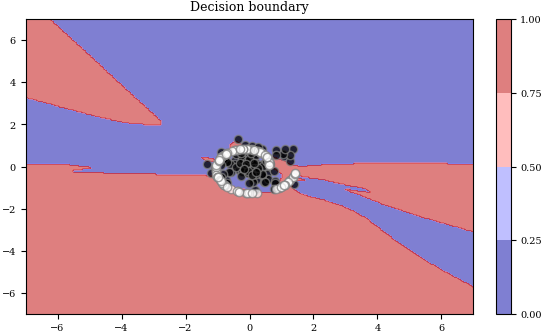

Depth: 2, Rank Init: 186, Rank Train: 346
Epoch 10, loss 130.527, accuracy 0.675
Epoch 20, loss 101.573, accuracy 0.750
Epoch 30, loss 75.261, accuracy 0.880
Epoch 40, loss 63.446, accuracy 0.875
Epoch 50, loss 60.450, accuracy 0.895
Epoch 60, loss 56.978, accuracy 0.865
Epoch 70, loss 51.360, accuracy 0.905
Epoch 80, loss 48.182, accuracy 0.925
Epoch 90, loss 44.973, accuracy 0.950
Epoch 100, loss 44.183, accuracy 0.935
Epoch 110, loss 43.434, accuracy 0.945
Epoch 120, loss 68.292, accuracy 0.895
Epoch 130, loss 52.218, accuracy 0.885
Epoch 140, loss 41.495, accuracy 0.950
Epoch 150, loss 37.764, accuracy 0.945
Epoch 160, loss 35.300, accuracy 0.945
Epoch 170, loss 33.686, accuracy 0.945
Epoch 180, loss 32.665, accuracy 0.950
Epoch 190, loss 31.715, accuracy 0.955
Epoch 200, loss 30.934, accuracy 0.955
Epoch 210, loss 30.220, accuracy 0.955
Epoch 220, loss 29.575, accuracy 0.955
Epoch 230, loss 28.985, accuracy 0.955
Epoch 240, loss 28.422, accuracy 0.955
Epoch 250, loss 27.869, accur

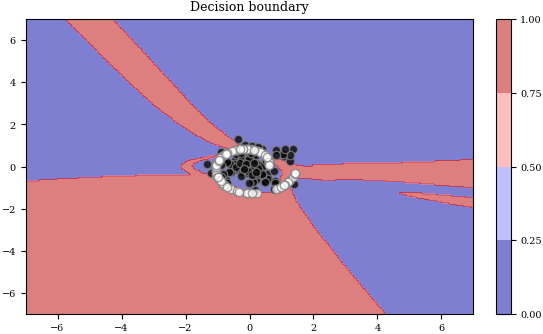

Depth: 4, Rank Init: 221, Rank Train: 365
Epoch 10, loss 123.393, accuracy 0.670
Epoch 20, loss 95.429, accuracy 0.795
Epoch 30, loss 77.270, accuracy 0.795
Epoch 40, loss 69.154, accuracy 0.885
Epoch 50, loss 55.572, accuracy 0.885
Epoch 60, loss 62.115, accuracy 0.915
Epoch 70, loss 49.373, accuracy 0.895
Epoch 80, loss 48.175, accuracy 0.930
Epoch 90, loss 43.085, accuracy 0.925
Epoch 100, loss 43.895, accuracy 0.925
Epoch 110, loss 65.798, accuracy 0.805
Epoch 120, loss 84.944, accuracy 0.850
Epoch 130, loss 67.419, accuracy 0.880
Epoch 140, loss 58.145, accuracy 0.900
Epoch 150, loss 50.676, accuracy 0.925
Epoch 160, loss 39.618, accuracy 0.945
Epoch 170, loss 34.711, accuracy 0.945
Epoch 180, loss 32.116, accuracy 0.940
Epoch 190, loss 29.940, accuracy 0.955
Epoch 200, loss 25.793, accuracy 0.960
Epoch 210, loss 23.852, accuracy 0.970
Epoch 220, loss 77.428, accuracy 0.905
Epoch 230, loss 34.983, accuracy 0.950
Epoch 240, loss 33.316, accuracy 0.875
Epoch 250, loss 74.403, accura

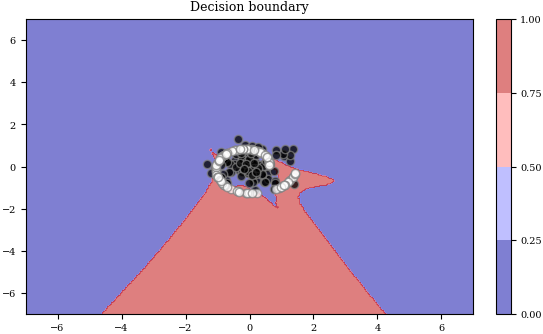

Depth: 6, Rank Init: 228, Rank Train: 339
Epoch 10, loss 127.003, accuracy 0.670
Epoch 20, loss 86.062, accuracy 0.790
Epoch 30, loss 88.885, accuracy 0.740
Epoch 40, loss 78.163, accuracy 0.815
Epoch 50, loss 64.693, accuracy 0.860
Epoch 60, loss 119.928, accuracy 0.705
Epoch 70, loss 98.861, accuracy 0.780
Epoch 80, loss 85.261, accuracy 0.820
Epoch 90, loss 87.240, accuracy 0.810
Epoch 100, loss 75.389, accuracy 0.820
Epoch 110, loss 66.341, accuracy 0.850
Epoch 120, loss 57.041, accuracy 0.890
Epoch 130, loss 51.192, accuracy 0.900
Epoch 140, loss 62.842, accuracy 0.930
Epoch 150, loss 44.996, accuracy 0.940
Epoch 160, loss 73.798, accuracy 0.880
Epoch 170, loss 54.163, accuracy 0.900
Epoch 180, loss 45.845, accuracy 0.920
Epoch 190, loss 62.374, accuracy 0.895
Epoch 200, loss 52.250, accuracy 0.915
Epoch 210, loss 48.156, accuracy 0.920
Epoch 220, loss 42.482, accuracy 0.935
Epoch 230, loss 36.940, accuracy 0.950
Epoch 240, loss 160.435, accuracy 0.865
Epoch 250, loss 99.818, accu

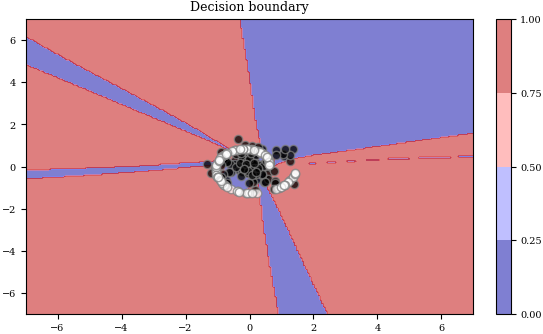

Depth: 8, Rank Init: 236, Rank Train: 308
Epoch 10, loss 131.999, accuracy 0.655
Epoch 20, loss 90.907, accuracy 0.790
Epoch 30, loss 87.390, accuracy 0.750
Epoch 40, loss 74.474, accuracy 0.825
Epoch 50, loss 81.641, accuracy 0.795
Epoch 60, loss 75.171, accuracy 0.815
Epoch 70, loss 94.224, accuracy 0.660
Epoch 80, loss 97.906, accuracy 0.735
Epoch 90, loss 79.890, accuracy 0.810
Epoch 100, loss 108.055, accuracy 0.815
Epoch 110, loss 77.080, accuracy 0.820
Epoch 120, loss 66.300, accuracy 0.855
Epoch 130, loss 96.316, accuracy 0.755
Epoch 140, loss 66.515, accuracy 0.850
Epoch 150, loss 58.852, accuracy 0.845
Epoch 160, loss 102.104, accuracy 0.685
Epoch 170, loss 78.973, accuracy 0.820
Epoch 180, loss 96.271, accuracy 0.765
Epoch 190, loss 83.355, accuracy 0.795
Epoch 200, loss 74.083, accuracy 0.805
Epoch 210, loss 93.892, accuracy 0.810
Epoch 220, loss 74.810, accuracy 0.845
Epoch 230, loss 61.753, accuracy 0.875
Epoch 240, loss 55.578, accuracy 0.885
Epoch 250, loss 54.037, accu

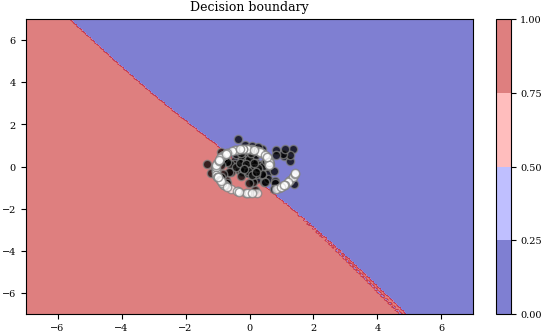

Depth: 10, Rank Init: 251, Rank Train: 337


In [21]:
width = 32
depth_list = jnp.array([2, 4, 6, 8, 10])
rank_init_list, rank_train_list, num_params_list = [], [], []
for depth in depth_list:
  rank_init, rank_train, num_params = rank(width, depth, key)
  rank_init_list.append(rank_init)
  rank_train_list.append(rank_train)
  num_params_list.append(num_params)
  print(f"Depth: {depth}, Rank Init: {rank_init}, Rank Train: {rank_train}")
ker_init_list, ker_train_list = [p - r for p,r in zip(num_params_list, rank_init_list)], [p - r for p,r in zip(num_params_list, rank_train_list)]

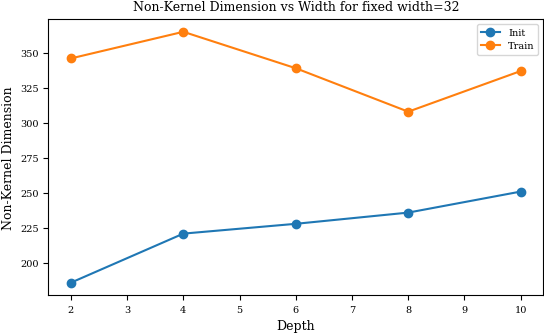

In [22]:
plt.plot(depth_list, rank_init_list, marker='o', label="Init")
plt.plot(depth_list, rank_train_list, marker='o', label="Train")
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Non-Kernel Dimension")
plt.title("Non-Kernel Dimension vs Width for fixed width=32")
plt.savefig("fixed_width_32.pdf")

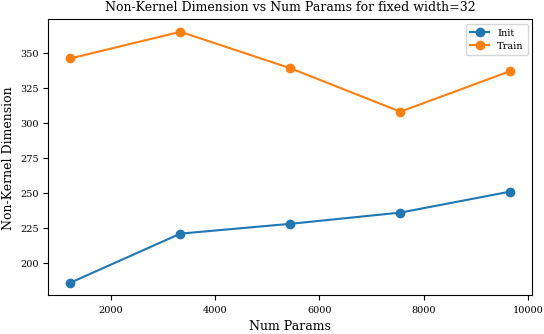

In [23]:
plt.plot(num_params_list, rank_init_list, marker='o', label="Init")
plt.plot(num_params_list, rank_train_list, marker='o', label="Train")
plt.legend()
plt.xlabel("Num Params")
plt.ylabel("Non-Kernel Dimension")
plt.title("Non-Kernel Dimension vs Num Params for fixed width=32")
plt.savefig("fixed_width_vs_num_params.pdf")
